In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Before and After Vaccination Data Prediction

##Common libraries and data

####Importing libraries for basic data processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

####Downloading and sorting dataset

In [3]:
#Before and after vaccination - only covid data
global_data = pd.read_csv("/content/drive/MyDrive/Final Year Project/saved data/covidData_withISO.csv")

#Before Vaccination
covid_df = pd.read_csv("/content/drive/MyDrive/Final Year Project/saved data/covid_beforeVaccination_dataset.csv")

# #After vaccination
# covid_df = pd.read_csv("/content/drive/MyDrive/Final Year Project/saved data/covid_afterVaccination_dataset.csv")

covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60795 entries, 0 to 60794
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       60795 non-null  int64 
 1   Unnamed: 0.1     60795 non-null  int64 
 2   Country/Region   60795 non-null  object
 3   dates            60795 non-null  object
 4   confirmed_cases  60795 non-null  int64 
 5   iso_code         60795 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.8+ MB


In [4]:
global_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150540 entries, 0 to 150539
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       150540 non-null  int64 
 1   Country/Region   150540 non-null  object
 2   dates            150540 non-null  object
 3   confirmed_cases  150540 non-null  int64 
 4   iso_code         150540 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.7+ MB


In [5]:
covid_df.dates = pd.to_datetime(covid_df.dates,infer_datetime_format=True)
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60795 entries, 0 to 60794
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       60795 non-null  int64         
 1   Unnamed: 0.1     60795 non-null  int64         
 2   Country/Region   60795 non-null  object        
 3   dates            60795 non-null  datetime64[ns]
 4   confirmed_cases  60795 non-null  int64         
 5   iso_code         60795 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 2.8+ MB


In [6]:
covid_df

,Unnamed: 0,Unnamed: 0.1,Country/Region,dates,confirmed_cases,iso_code
0,0,0,Afghanistan,2020-01-22,0,AFG
1,1,1,Afghanistan,2020-01-23,0,AFG
2,2,2,Afghanistan,2020-01-24,0,AFG
3,3,3,Afghanistan,2020-01-25,0,AFG
4,4,4,Afghanistan,2020-01-26,0,AFG
...,...,...,...,...,...,...
60790,150070,153970,Zimbabwe,2020-11-27,519347,ZWE
60791,150071,153971,Zimbabwe,2020-11-28,524966,ZWE
60792,150072,153972,Zimbabwe,2020-11-29,529540,ZWE
60793,150073,153973,Zimbabwe,2020-11-30,533596,ZWE


##LSTM / GRU

####Data preprocessing

In [7]:
covid_sorted_df = {}
for country in covid_df['Country/Region'].unique():
  min_date = covid_df[covid_df['Country/Region'] == country].dates.min()
  covid_sorted_df[country] = covid_df[covid_df['Country/Region'] == country].sort_values(by=['dates']).copy()
  covid_sorted_df[country]['days'] = (covid_sorted_df[country].dates - min_date).dt.days

In [8]:
covid_sorted_df['Afghanistan'].days.min()

0

In [9]:
covid_sorted_df['India']

,Unnamed: 0,Unnamed: 0.1,Country/Region,dates,confirmed_cases,iso_code,days
24885,61620,62400,India,2020-01-22,64,IND,0
24886,61621,62401,India,2020-01-23,124,IND,1
24887,61622,62402,India,2020-01-24,226,IND,2
24888,61623,62403,India,2020-01-25,395,IND,3
24889,61624,62404,India,2020-01-26,638,IND,4
...,...,...,...,...,...,...,...
25195,61930,62710,India,2020-11-27,11635,IND,310
25196,61931,62711,India,2020-11-28,11645,IND,311
25197,61932,62712,India,2020-11-29,11662,IND,312
25198,61933,62713,India,2020-11-30,11674,IND,313


In [10]:
len(covid_sorted_df) == covid_df['Country/Region'].nunique()

True

####Functios for processing data

In [11]:
def create_dataset(n_X, look_back):
   dataX, dataY = [], []
   for i in range(len(n_X)-look_back):
      a = n_X[i:(i+look_back), ]
      dataX.append(a)
      dataY.append(n_X[i + look_back, ])
   return np.array(dataX), np.array(dataY)

####Train test split data

In [12]:
#split 90%-10% as train-test for before vaccination
#split 80%-20% as train-test for after vaccination
train_data = {}
test_data = {}
scaler = {}

for country in covid_sorted_df.keys():
  #data
  scaling_df = global_data[global_data['Country/Region'] == country].copy()
  temp_df = covid_sorted_df[country].copy()

  #Before Vaccination
  train_data_size = int(0.9*temp_df.shape[0])
  
  # #After Vaccination
  # train_data_size = int(0.8*temp_df.shape[0])
  
#Scaling Data=============================================
  #Before Vaccination---------------------------------------
  scaler[country] = MinMaxScaler(feature_range=(0, 1))

  #Fitting data
  global_x = scaling_df.confirmed_cases.values
  global_x = global_x.reshape(len(global_x), 1)
  scaler[country].fit(global_x)

  #transforming data
  x = temp_df.confirmed_cases.values
  x = x.reshape((len(x), 1))
  x = scaler[country].transform(x)
  temp_df.confirmed_cases = np.reshape(x,len(x))
  
  #train data
  train_data[country] = temp_df.head(train_data_size)['confirmed_cases'].to_numpy(copy = True)
  
  #test data
  test_data[country] = temp_df.tail(temp_df.shape[0] - train_data_size)['confirmed_cases'].to_numpy(copy = True)
  
  
  
  # #After Vaccination---------------------------------------
  # scaler[country] = [MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))]
  
  # #Fitting data
  # global_x = scaling_df.confirmed_cases.values
  # global_x = global_x.reshape(len(global_x), 1)
  # scaler[country][1].fit(global_x)

  # #transforming data
  # x1 = temp_df.total_vaccination_per_day.values
  # x2 = temp_df.confirmed_cases.values
  # x1 = x1.reshape((len(x1), 1))
  # x2 = x2.reshape((len(x2), 1))
  # x1 = scaler[country][0].fit_transform(x1)
  # x2 = scaler[country][1].transform(x2)
  # temp_df.total_vaccination_per_day = np.reshape(x1, len(x1))
  # temp_df.confirmed_cases = np.reshape(x2, len(x2))
  
  # #train data
  # train_data[country] = temp_df.head(train_data_size)[['total_vaccination_per_day', 'confirmed_cases']].to_numpy(copy = True)
  
  # #test data
  # test_data[country] = temp_df.tail(temp_df.shape[0] - train_data_size)[['total_vaccination_per_day','confirmed_cases']].to_numpy(copy = True)

In [13]:
train_data['Afghanistan'][-5:]

array([0.23203996, 0.23263096, 0.23317081, 0.23381295, 0.23451192])

In [14]:
train_data.keys()

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'India', 'Ind

In [15]:
(train_data['Afghanistan'].shape, test_data['Afghanistan'].shape)

((283,), (32,))

In [16]:
#train data for model
train_x = {}
train_y = {}
#test data for model
test_x = {}
test_y = {}

#creating data for model
look_back = 7                 #change this value to select number of timestamps
for country in train_data.keys():
  train_x[country], train_y[country] = create_dataset(train_data[country], look_back)
  test_x[country], test_y[country] = create_dataset(test_data[country], look_back)
  
 #shape (sample, timesteps, features)
  # #AfterVaccination
  # train_x[country] = np.reshape(train_x[country], (train_x[country].shape[0], look_back, train_data[country].shape[1]))
  # test_x[country] = np.reshape(test_x[country], (test_x[country].shape[0], look_back, test_data[country].shape[1]))
  
  #BeforeVaccination
  train_x[country] = np.reshape(train_x[country], (train_x[country].shape[0], look_back, 1))
  test_x[country] = np.reshape(test_x[country], (test_x[country].shape[0], look_back, 1))

In [17]:
train_x['Afghanistan'][-2:]

array([[[0.23020446],
        [0.23086365],
        [0.23121029],
        [0.23167059],
        [0.23203996],
        [0.23263096],
        [0.23317081]],

       [[0.23086365],
        [0.23121029],
        [0.23167059],
        [0.23203996],
        [0.23263096],
        [0.23317081],
        [0.23381295]]])

In [18]:
train_y['Afghanistan'][-2:]

array([0.23381295, 0.23451192])

In [19]:
train_x['Afghanistan'].shape, train_y['Afghanistan'].shape

((276, 7, 1), (276,))

####Importing libraries for model

In [20]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

####Applying model

In [21]:
from keras import backend

def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

In [22]:
# custom_countries = {'India', 'US', 'Japan', 'Australia', 'Canada', 'China', 'France', 'Germany', 'Singapore', 'South Africa', 'Korea, South', 'United Kingdom' }
custom_countries = {'India', 'US', 'Australia', 'Albania', 'United Kingdom', 'South Africa' }

####LSTM

In [23]:
# for country in custom_countries:
# # for country in train_x.keys():
#   print(f"\n Country:{country}")
#   model_lstm = Sequential()
#   model_lstm.add(LSTM(512, return_sequences = True, input_shape = (train_x[country].shape[1], train_x[country].shape[2])))
#   model_lstm.add(LSTM(256, input_shape = (train_x[country].shape[1], train_x[country].shape[2])))
#   # model_lstm.add(LSTM(512, return_sequences = True, input_shape = (look_back, 1)))
#   # model_lstm.add(LSTM(256, input_shape = (look_back, 1)))

#   # #Before Vacciantion
#   # model_lstm.add(Dense(1))
#   #After Vaccination
#   model_lstm.add(Dense(2))

#   model_lstm.compile(loss='mean_squared_error', optimizer = 'adam', metrics=[keras.metrics.RootMeanSquaredError()])
#   model_lstm.fit(train_x[country], train_y[country],batch_size=10, epochs = 1000, verbose = 2, shuffle = False)
  
# #saving model trained
#   # #before vaccination------------------------------------------------------------
#   # filepath = "/content/drive/MyDrive/Final Year Project/LSTM_models/before_vaccination/"
#   #after vacciantion---------------------------------------------------------------
#   filepath = "/content/drive/MyDrive/Final Year Project/LSTM_models/after_vaccination/"

#   filepath = filepath + country
#   model_lstm.save(filepath)

####GRU

In [24]:
for country in custom_countries:
# for country in train_x.keys():
  print(f"\nCountry: {country}")
  model_GRU = Sequential()
  model_GRU.add(GRU(512, return_sequences = True, input_shape = (train_x[country].shape[1], train_x[country].shape[2])))
  model_GRU.add(GRU(256, input_shape = (test_x[country].shape[1], test_x[country].shape[2])))
  
  #Before vaccination----------------------------------------------
  model_GRU.add(Dense(1))
  # #After Vaccination-----------------------------------------------
  # model_GRU.add(Dense(2))

  model_GRU.compile(loss='mean_squared_error', optimizer = 'adam', metrics=[keras.metrics.RootMeanSquaredError()])
  # model_GRU.fit(train_x[country], train_y[country],batch_size=10, epochs = 1000, verbose = 2, shuffle = False)
  model_GRU.fit(train_x[country], train_y[country],batch_size=10, epochs = 2000, verbose = 2, shuffle = False)
  
  #saving model trained
  #before vaccination
  filepath = "/content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/"
  # #after vaccination
  # filepath = "/content/drive/MyDrive/Final Year Project/GRU_models/after_vaccination/"
  
  # filepath = filepath + country + ".h5"
  # model_GRU.save_weights(filepath)

  # filepath = filepath + country + "_1000"
  filepath = filepath + country
  model_GRU.save(filepath)


Country: India
Epoch 1/2000
28/28 - 8s - loss: 0.0047 - root_mean_squared_error: 0.0684 - 8s/epoch - 284ms/step
Epoch 2/2000
28/28 - 0s - loss: 3.0342e-04 - root_mean_squared_error: 0.0174 - 299ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 3.5931e-04 - root_mean_squared_error: 0.0190 - 299ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 1.4909e-04 - root_mean_squared_error: 0.0122 - 304ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 1.1110e-04 - root_mean_squared_error: 0.0105 - 300ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 1.3904e-04 - root_mean_squared_error: 0.0118 - 307ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 1.7637e-04 - root_mean_squared_error: 0.0133 - 298ms/epoch - 11ms/step
Epoch 8/2000
28/28 - 0s - loss: 1.8509e-04 - root_mean_squared_error: 0.0136 - 303ms/epoch - 11ms/step
Epoch 9/2000
28/28 - 0s - loss: 1.8619e-04 - root_mean_squared_error: 0.0136 - 304ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 1.8025e-04 - root_mean_squared

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/India/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/India/assets



Country: United Kingdom
Epoch 1/2000
28/28 - 4s - loss: 1.4093e-04 - root_mean_squared_error: 0.0119 - 4s/epoch - 132ms/step
Epoch 2/2000
28/28 - 0s - loss: 1.3239e-04 - root_mean_squared_error: 0.0115 - 311ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 1.3268e-04 - root_mean_squared_error: 0.0115 - 307ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 1.4649e-04 - root_mean_squared_error: 0.0121 - 311ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 1.7394e-04 - root_mean_squared_error: 0.0132 - 300ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 1.5272e-04 - root_mean_squared_error: 0.0124 - 300ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 1.7612e-04 - root_mean_squared_error: 0.0133 - 302ms/epoch - 11ms/step
Epoch 8/2000
28/28 - 0s - loss: 1.2362e-04 - root_mean_squared_error: 0.0111 - 314ms/epoch - 11ms/step
Epoch 9/2000
28/28 - 0s - loss: 9.6807e-05 - root_mean_squared_error: 0.0098 - 318ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 1.0784e-04 - root

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/United Kingdom/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/United Kingdom/assets



Country: Australia
Epoch 1/2000
28/28 - 4s - loss: 5.2127e-05 - root_mean_squared_error: 0.0072 - 4s/epoch - 130ms/step
Epoch 2/2000
28/28 - 0s - loss: 7.7805e-06 - root_mean_squared_error: 0.0028 - 303ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 3.0257e-06 - root_mean_squared_error: 0.0017 - 314ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 2.2376e-06 - root_mean_squared_error: 0.0015 - 312ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 1.6555e-06 - root_mean_squared_error: 0.0013 - 302ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 1.3019e-06 - root_mean_squared_error: 0.0011 - 306ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 1.1887e-06 - root_mean_squared_error: 0.0011 - 298ms/epoch - 11ms/step
Epoch 8/2000
28/28 - 0s - loss: 1.1520e-06 - root_mean_squared_error: 0.0011 - 319ms/epoch - 11ms/step
Epoch 9/2000
28/28 - 0s - loss: 1.1557e-06 - root_mean_squared_error: 0.0011 - 313ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 1.1766e-06 - root_mean

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/Australia/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/Australia/assets



Country: Albania
Epoch 1/2000
28/28 - 4s - loss: 1.0668e-04 - root_mean_squared_error: 0.0103 - 4s/epoch - 131ms/step
Epoch 2/2000
28/28 - 0s - loss: 4.4697e-04 - root_mean_squared_error: 0.0211 - 315ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 5.6163e-04 - root_mean_squared_error: 0.0237 - 296ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 3.5998e-04 - root_mean_squared_error: 0.0190 - 312ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 4.1892e-04 - root_mean_squared_error: 0.0205 - 298ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 4.0137e-04 - root_mean_squared_error: 0.0200 - 299ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 4.3381e-04 - root_mean_squared_error: 0.0208 - 337ms/epoch - 12ms/step
Epoch 8/2000
28/28 - 0s - loss: 4.7068e-04 - root_mean_squared_error: 0.0217 - 327ms/epoch - 12ms/step
Epoch 9/2000
28/28 - 0s - loss: 4.7428e-04 - root_mean_squared_error: 0.0218 - 311ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 4.7071e-04 - root_mean_s

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/Albania/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/Albania/assets



Country: US
Epoch 1/2000
28/28 - 4s - loss: 1.0507e-04 - root_mean_squared_error: 0.0103 - 4s/epoch - 146ms/step
Epoch 2/2000
28/28 - 0s - loss: 1.3160e-05 - root_mean_squared_error: 0.0036 - 321ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 4.2929e-06 - root_mean_squared_error: 0.0021 - 300ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 3.1244e-06 - root_mean_squared_error: 0.0018 - 303ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 3.6938e-06 - root_mean_squared_error: 0.0019 - 299ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 4.0947e-06 - root_mean_squared_error: 0.0020 - 318ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 4.1377e-06 - root_mean_squared_error: 0.0020 - 326ms/epoch - 12ms/step
Epoch 8/2000
28/28 - 0s - loss: 4.0470e-06 - root_mean_squared_error: 0.0020 - 309ms/epoch - 11ms/step
Epoch 9/2000
28/28 - 0s - loss: 3.9640e-06 - root_mean_squared_error: 0.0020 - 311ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 3.9299e-06 - root_mean_square

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/US/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/US/assets



Country: South Africa
Epoch 1/2000
28/28 - 4s - loss: 1.6330e-04 - root_mean_squared_error: 0.0128 - 4s/epoch - 131ms/step
Epoch 2/2000
28/28 - 0s - loss: 9.7683e-04 - root_mean_squared_error: 0.0313 - 310ms/epoch - 11ms/step
Epoch 3/2000
28/28 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0526 - 303ms/epoch - 11ms/step
Epoch 4/2000
28/28 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0564 - 306ms/epoch - 11ms/step
Epoch 5/2000
28/28 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0590 - 315ms/epoch - 11ms/step
Epoch 6/2000
28/28 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0697 - 303ms/epoch - 11ms/step
Epoch 7/2000
28/28 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - 301ms/epoch - 11ms/step
Epoch 8/2000
28/28 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0453 - 345ms/epoch - 12ms/step
Epoch 9/2000
28/28 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0516 - 307ms/epoch - 11ms/step
Epoch 10/2000
28/28 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0762 - 307m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/South Africa/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/South Africa/assets


##Prediction

In [25]:
from keras.models import load_model
countryDict = {'India', 'US', 'Australia', 'Albania', 'United Kingdom', 'South Africa' }

###Loading models and libraries (epoch = 2000)

In [26]:
# Saved models loaded from a file
model_gru = {}
#model_lstm = {}

#days for each country
days_train = {}
days_test = {}

#output to change dimension
y_test = {}
y_train = {}

# Variables to store predictions
pred_gru_test = {}
pred_gru_train = {}

In [27]:
#Before vaccination
for country in countryDict:
  model_gru[country] = load_model(f"/content/drive/MyDrive/Final Year Project/GRU_models/before_vaccination/{country}")
  # model_lstm[country] = load_model(f"/content/drive/MyDrive/Final Year Project/LSTM_models/before_vaccination/{country}")

In [28]:
test_x['India'].shape

(25, 7, 1)

In [29]:
#prediction
for country in countryDict:
  temp_test_df = covid_sorted_df[country].tail(test_y[country].shape[0])
  temp_train_df = covid_sorted_df[country].head(train_y[country].shape[0])
  
  days_test[country] = temp_test_df.dates
  days_train[country] = temp_train_df.dates

  test_pred = model_gru[country].predict(test_x[country])
  train_pred = model_gru[country].predict(train_x[country])

  pred_gru_test[country] = scaler[country].inverse_transform(test_pred)
  # pred_gru_test[country] = test_pred
  pred_gru_train[country] = scaler[country].inverse_transform(train_pred)
  
  # test_y[country].reshape(-1, 1)
  # train_y[country].reshape(-1, 1)

  # print(test_pred.shape, test_y[country].shape)

  y_test[country] = scaler[country].inverse_transform(test_y[country].reshape(-1, 1))
  y_train[country] = scaler[country].inverse_transform(train_y[country].reshape(-1, 1))

In [30]:
for country in countryDict:
  print(f"{country}:\t{pred_gru_test[country].shape}")

India:	(25, 1)
United Kingdom:	(25, 1)
Australia:	(25, 1)
Albania:	(25, 1)
US:	(25, 1)
South Africa:	(25, 1)


####Plotting prediction on Test Data

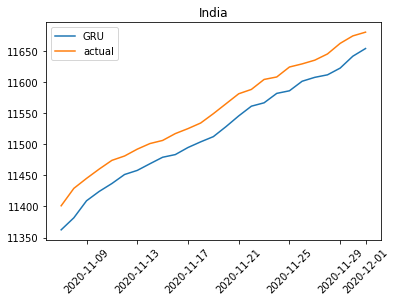

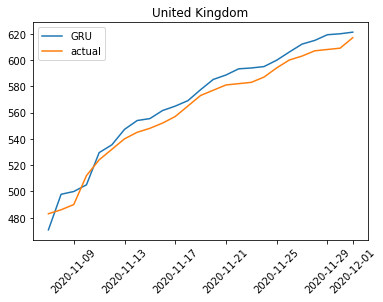

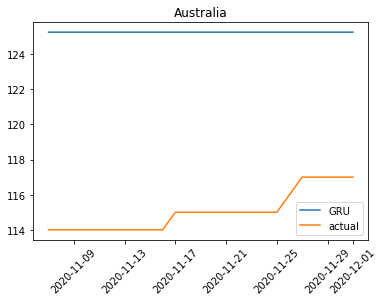

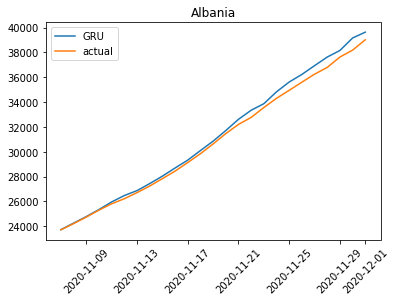

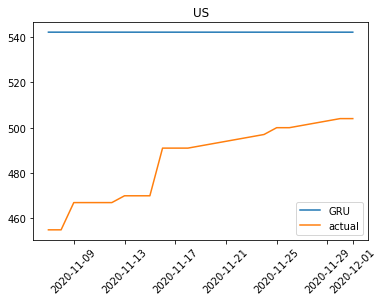

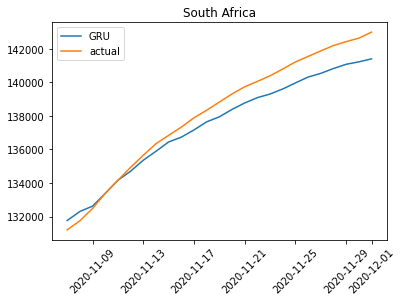

In [31]:
for country in countryDict:
  X =  days_test[country]
  plt.plot(X, pred_gru_test[country])
  plt.plot(X, y_test[country])
  # plt.legend(['LSTM', 'GRU', 'actual'])
  plt.legend(['GRU', 'actual'])
  plt.xticks(rotation = 45)
  plt.title(country)
  plt.show()

####Plotting prediction on Training Data

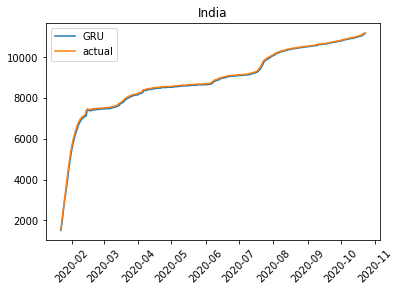

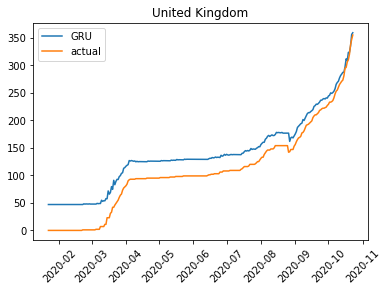

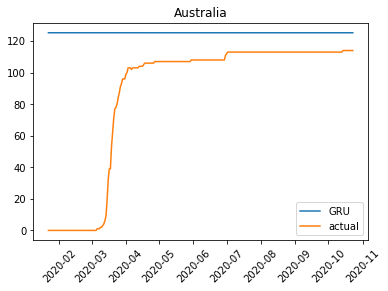

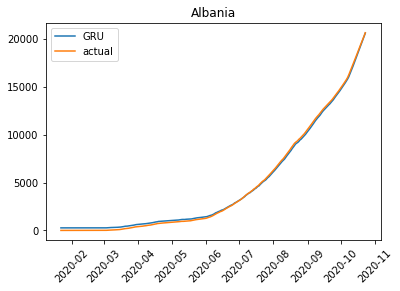

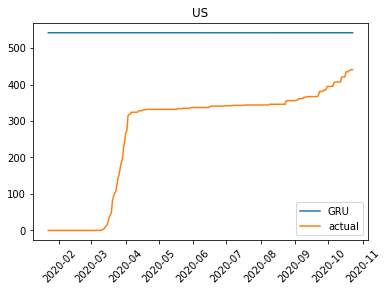

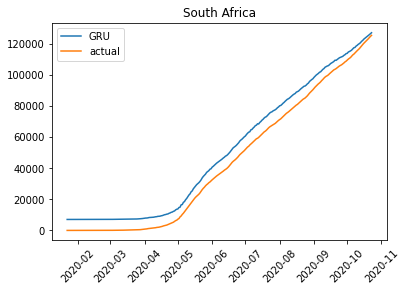

In [32]:
for country in countryDict:
  X =  days_train[country]
  plt.plot(X, pred_gru_train[country])
  plt.plot(X, y_train[country])
  # plt.legend(['LSTM', 'GRU', 'actual'])
  plt.legend(['GRU', 'actual'])
  plt.xticks(rotation = 45)
  plt.title(country)
  plt.show()